In [1]:
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf
from audiotools.data.datasets import AudioDataset, AudioLoader
from audiotools import AudioSignal
from audiotools import transforms as tfm
import torch

def get_config(config_name="evaluate_model_illm", overrides=[]):
    with initialize(version_base=None, config_path="src/tf_encodec/conf"):
        return compose(config_name=config_name, overrides=overrides)

def get_dataloader(cfg: DictConfig):
    loader = AudioLoader(
        sources=[cfg.dataset.test_data],
        transform=tfm.Equalizer(),
        ext=["wav", "mp3", "flac"],
        shuffle_state=0,
    )

    dataset = AudioDataset(
        loaders = [loader],
        sample_rate = 44100,
        num_channels = 1,
        n_examples = cfg.num_evals,
        duration = 1,
        transform = tfm.RescaleAudio(),
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        collate_fn=dataset.collate,
    )
    return dataloader

In [4]:
cfg = get_config(overrides=["batch_size=4", "tifresi.n_stft=1024"])
print(OmegaConf.to_yaml(cfg))

tifresi:
  n_stft: 1024
  hop_size: 128
  db_range: 50
audio:
  sample_rate: 44100
dataset:
  test_data: /home/philipp/projects/tf_encodec/assets/audio/
  train_data: /home/philipp/projects/tf_encodec/assets/audio/
evaluate:
  method: bypass
batch_size: 4
device: cpu
duration: 5
num_evals: 6
num_workers: 0



In [5]:
dataloader = get_dataloader(cfg)
batch = next(iter(dataloader))["signal"]
print(batch.audio_data.shape)

torch.Size([4, 1, 44100])


In [6]:
from tf_encodec.conversion import TFConverter

converter = TFConverter(cfg.tifresi.n_stft,
                        cfg.tifresi.hop_size,
                        cfg.tifresi.db_range,
                        cfg.audio.sample_rate)

batch.normalize()
specs = converter.convert_batch_to_spectrograms(batch)
print(specs.shape)

torch.Size([4, 3, 512, 344])


In [7]:
from einops import rearrange
specs_draw = rearrange(specs, "b c h w -> b h w c")
print(specs_draw.shape)

torch.Size([4, 512, 344, 3])


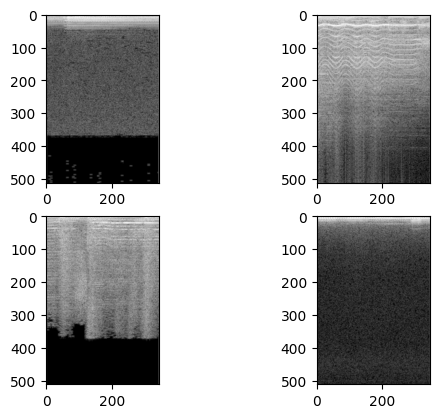

In [8]:
from tifresi import pyplot as plt
fig,axs = plt.subplots(2,2)
axs[0,0].imshow(specs_draw[0,:,:,:])
axs[0,1].imshow(specs_draw[1,:,:,:])
axs[1,0].imshow(specs_draw[2,:,:,:])
axs[1,1].imshow(specs_draw[3,:,:,:])

In [10]:
from einops import reduce
import numpy as np
from torchaudio.transforms import MelScale

def batch_img_to_mel_spec(imgs):
    # Take average over RGB channels
    imgs = reduce(imgs, 'b c h w -> b h w ', 'mean')
    # Back to log scale
    log_S = imgs * 50 - 50
    # Inverse log
    #S = np.exp(log_S)
    # Mel scale transform
    mels = MelScale(n_mels=80, sample_rate=44100, n_stft=512)(log_S)
    return mels

mels = batch_img_to_mel_spec(specs)

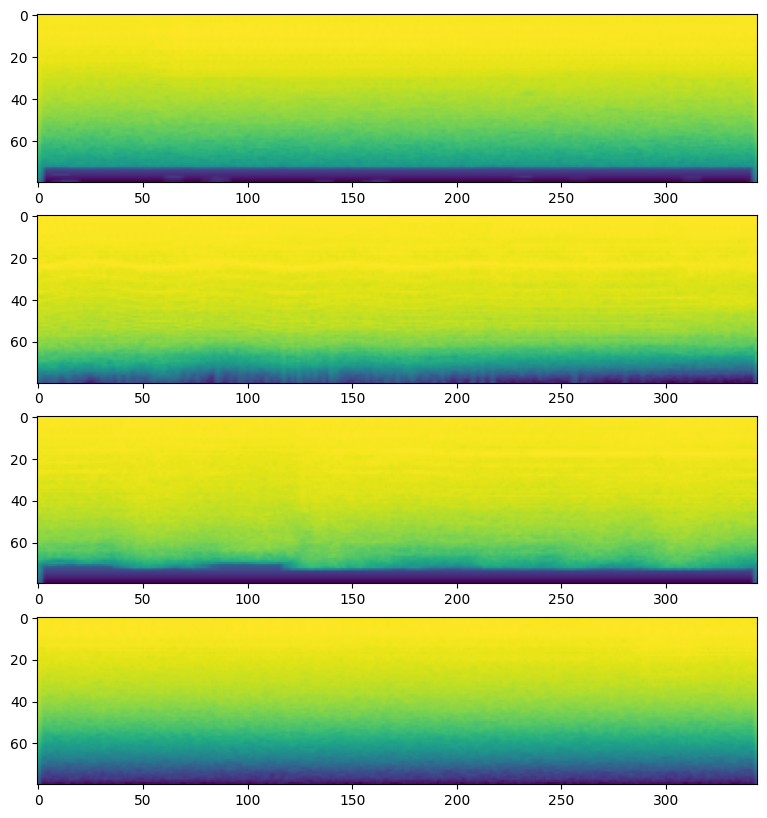

In [11]:
from tifresi import pyplot as plt
fig,axs = plt.subplots(4,1,  figsize=(20,10))
axs[0].imshow(mels[0,:,:])
axs[1].imshow(mels[1,:,:])
axs[2].imshow(mels[2,:,:])
axs[3].imshow(mels[3,:,:])

In [18]:
import torch.nn as nn

class MelSpecLoss(nn.Module):
    def __init__(self,
                 n_stft: int = 512,
                 sample_rate: int = 44100,
                 n_mels: int = 80,):

        super().__init__()
        self.mel_scale = MelScale(n_mels=n_mels,
                                  sample_rate=sample_rate,
                                  n_stft=n_stft)

    def forward(self, x, y):
        # Take average over RGB channels
        x = reduce(x, 'b c h w -> b h w ', 'mean')
        y = reduce(y, 'b c h w -> b h w ', 'mean')
        # Back to log scale
        #x = x * 50 - 50
        #y = y * 50 - 50
        return torch.mean((self.mel_scale(x) - self.mel_scale(y))**2)


In [19]:
mel_loss = MelSpecLoss(n_stft = 512, sample_rate=44100, n_mels=80)
loss = mel_loss(specs, specs/2)

In [20]:
print(loss)

tensor(1.9580)
